# Strategy V4.2

In [ ]:
from pandas import DataFrame, Series
from typing import List, Dict, Tuple
from numpy import ndarray

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

returns_lookforward: int = 1
CUTOFF: int = 60
ema_lookback: int = 5

In [ ]:
def get_non_stationary_instruments(start_index: int, end_index: int) -> Dict[int, DataFrame]:
	raw_prices: DataFrame = pd.read_csv("../../prices.txt", sep=r"\s+", index_col=None, header=None)
	price_history: ndarray = raw_prices.values[start_index:end_index][:].T
	data: Dict[int, DataFrame] = {}

	for instrument_no in range(0, 50):
		result = adfuller(price_history[instrument_no], autolag="AIC")

		if result[1] > 0.05:
			data[instrument_no] = pd.DataFrame(columns=["price"])
			data[instrument_no]["price"] = price_history[instrument_no] 

	return data


def implement_response(data: Dict[int, DataFrame]) -> Dict[int, DataFrame]:
	for instrument_no in data:
		# Get prices now and prices in n days
		prices_now: Series = data[instrument_no]["price"]
		prices_future: Series = data[instrument_no]["price"].shift(-returns_lookforward)
								 
		
		data[instrument_no]["response"] = prices_future / prices_now 
		
		# Clip data
		data[instrument_no] = data[instrument_no].iloc[:-returns_lookforward]

	return data


### Feature Engineering

In [ ]:
def implement_rsi(data: Dict[int, DataFrame], params: Dict[int, Dict[str, float | int]]) -> (
		Dict)[int, DataFrame]:
	for instrument_no in data:
		delta_prices: Series = data[instrument_no]["price"].diff()

		gains: Series= delta_prices.clip(lower=0)
		losses: Series = -delta_prices.clip(upper=0)

		avg_gain: Series = gains.rolling(window=params[instrument_no]["rsi_lookback"]).mean()
		avg_loss: Series = losses.rolling(window=params[instrument_no]["rsi_lookback"]).mean()

		relative_strength: Series = avg_gain / avg_loss
		relative_strength_index: Series = 100 - (100 / (1 + relative_strength))
		relative_strength_index.iloc[:params[instrument_no]["rsi_lookback"]] = 0.0
		data[instrument_no]["rsi"] = relative_strength_index

	return data

def implement_volatility(data: Dict[int, DataFrame], params: Dict[int, Dict[str, float | int]]) -> (
		Dict)[int, DataFrame]:
	for instrument_no in data:
		prices_window: Series= data[instrument_no]["price"]
		returns: Series = prices_window.pct_change()
		volatility: Series = returns.rolling(window=params[instrument_no]["vol_lookback"]).std()
		data[instrument_no]["volatility"] = volatility

	return data

# Positive: Slow EMA > Fast EMA 
# Negative: Slow EMA < Fast EMA 
def implement_ema_crossover(data: Dict[int, DataFrame], params: Dict[int, Dict[str, float | int]]
) -> Dict[int, DataFrame]:
	for instrument_no in data:
		prices_window: Series = data[instrument_no]["price"]
		slow_lookback: int = params[instrument_no]["slow_ema_lookback"]
		fast_lookback: int = params[instrument_no]["fast_ema_lookback"]

		slow_ema: Series = prices_window.ewm(span=slow_lookback, adjust=False).mean()
		fast_ema: Series = prices_window.ewm(span=fast_lookback, adjust=False).mean()

		crossover_gap: Series = slow_ema - fast_ema
		crossover_gap.iloc[:slow_lookback] = 0.0
		data[instrument_no]["ema_crossover"] = crossover_gap

	return data

def implement_returns(data: Dict[int, DataFrame]) -> Dict[int, DataFrame]:
	for instrument_no in data:
		returns: Series = data[instrument_no]["price"].diff().dropna()
		
		data[instrument_no]["returns"] = returns
	
	return data

### Checking the Relationship of Features vs. Response

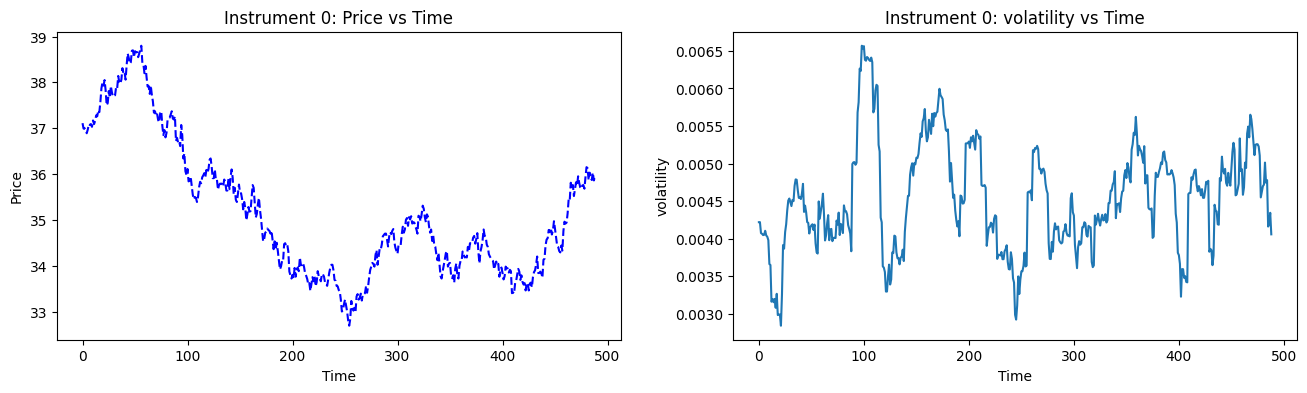

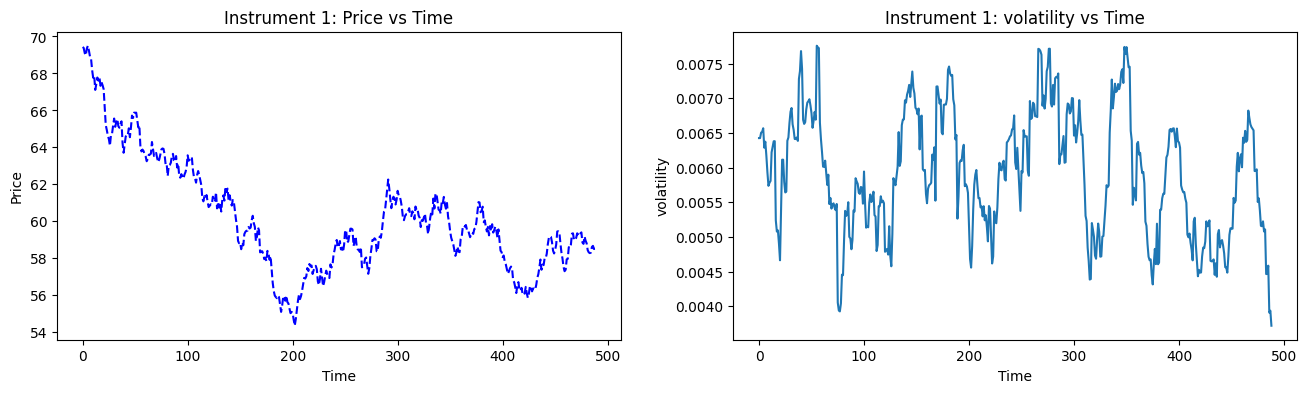

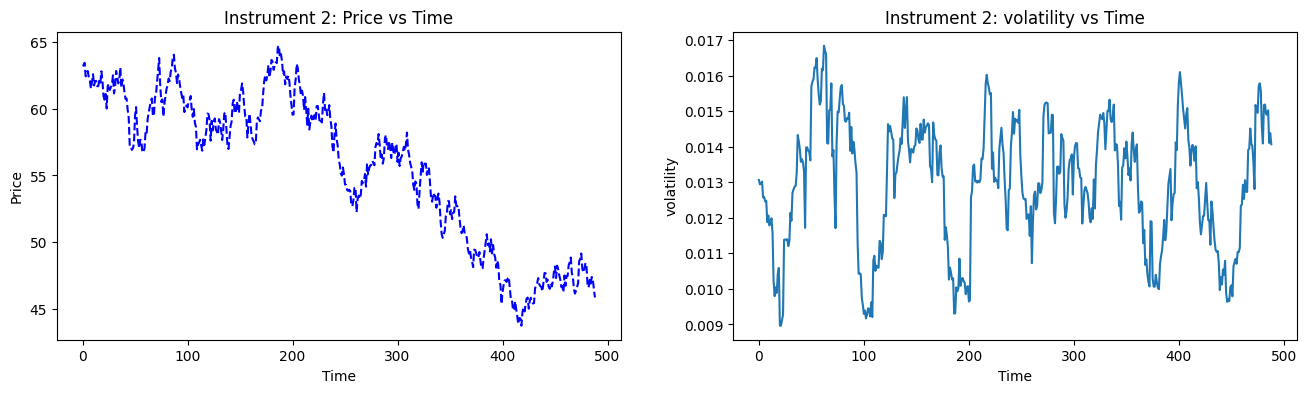

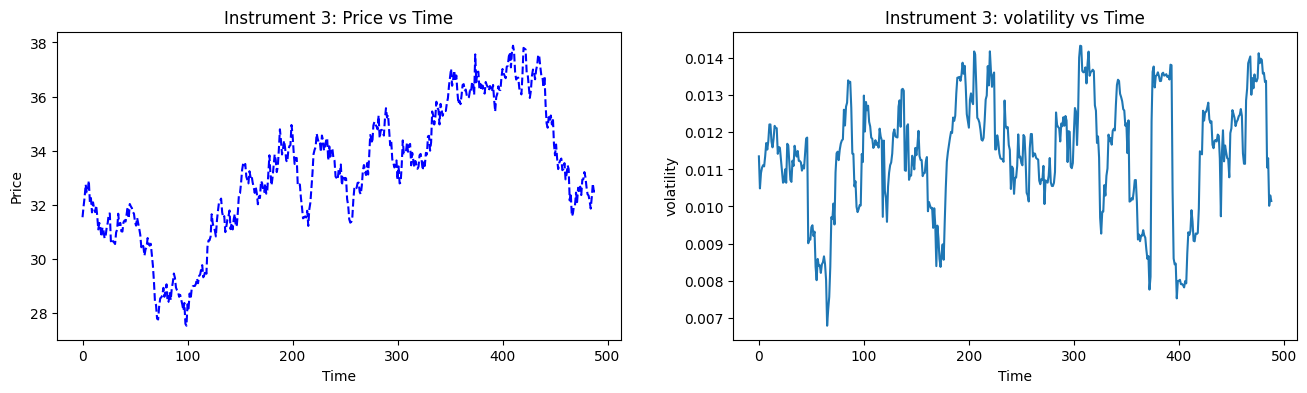

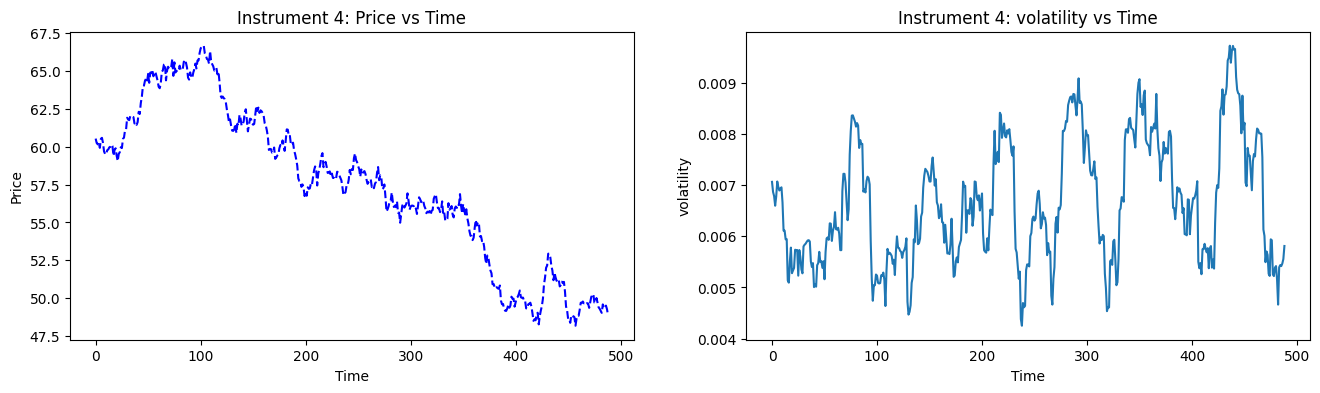

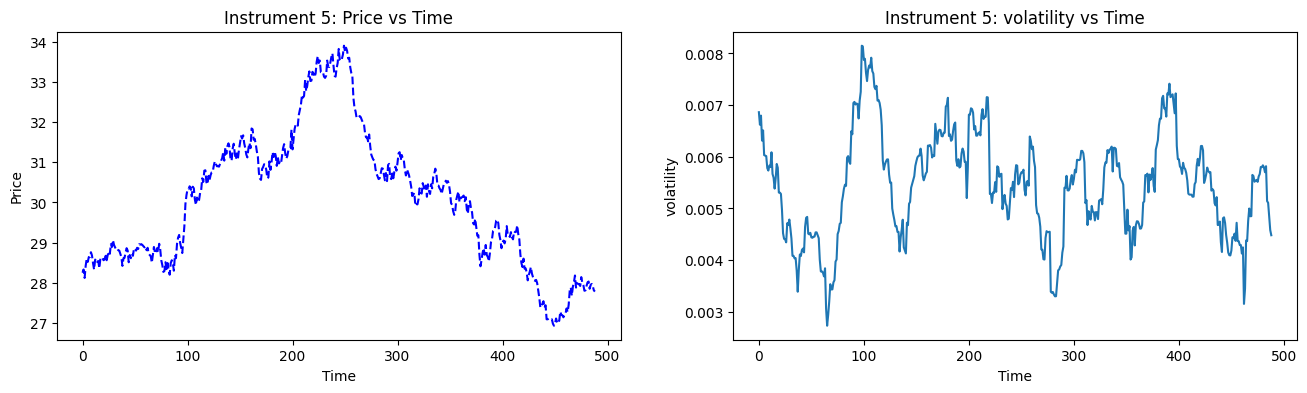

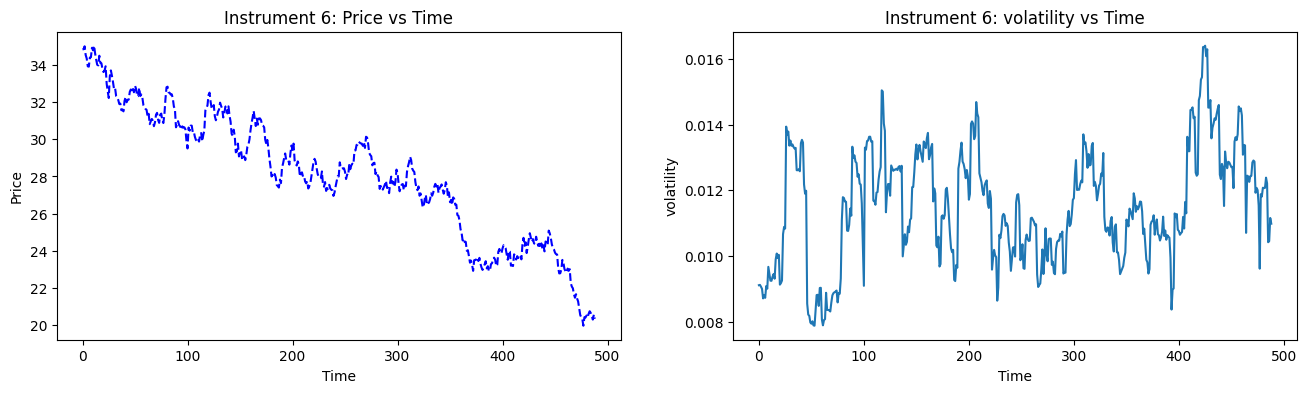

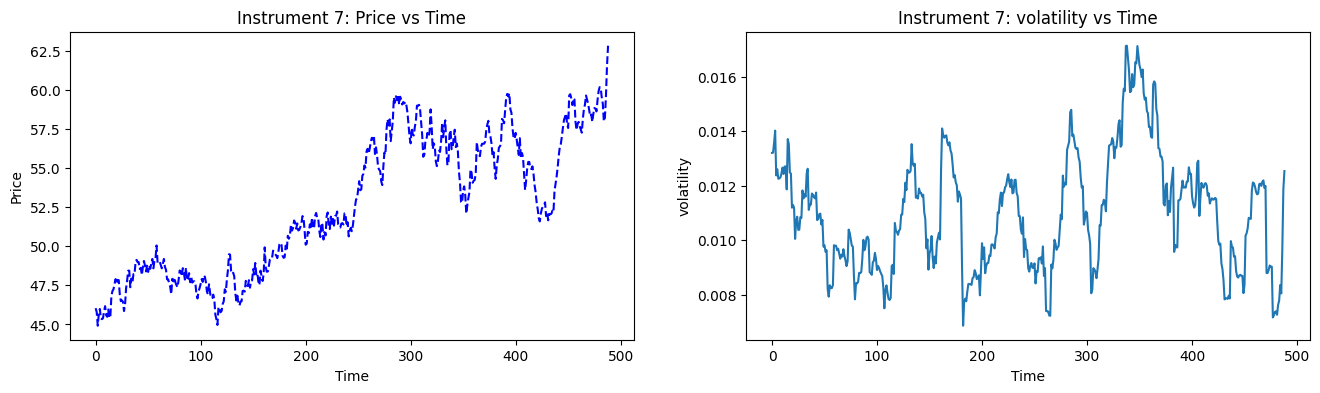

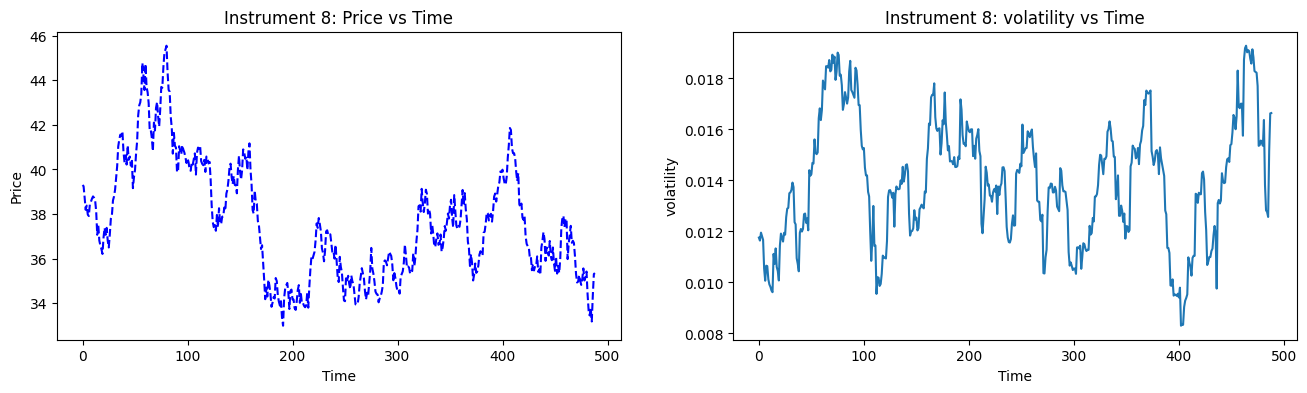

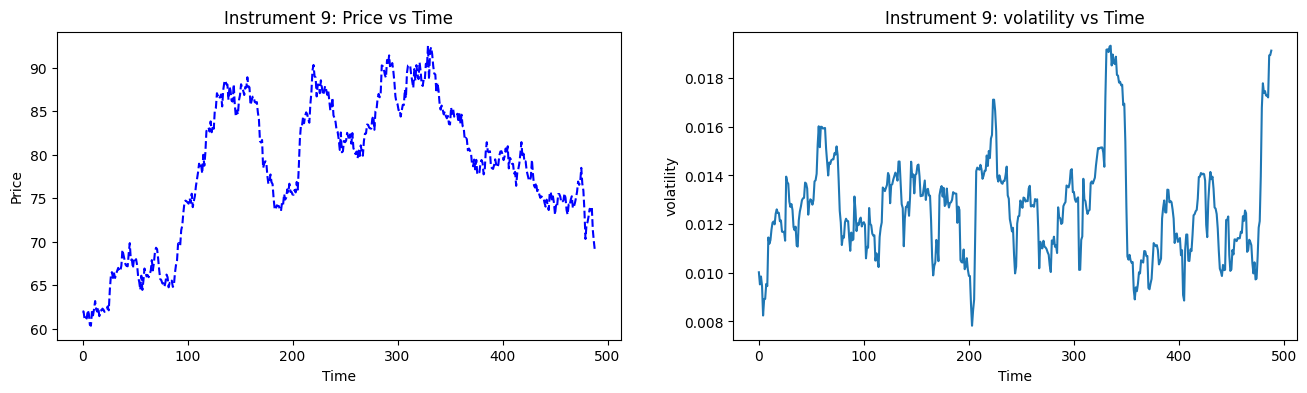

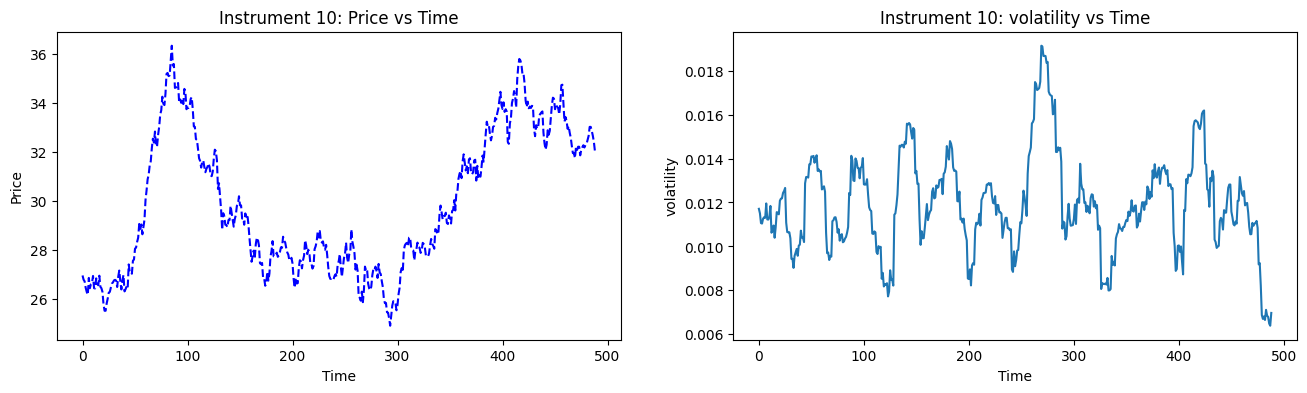

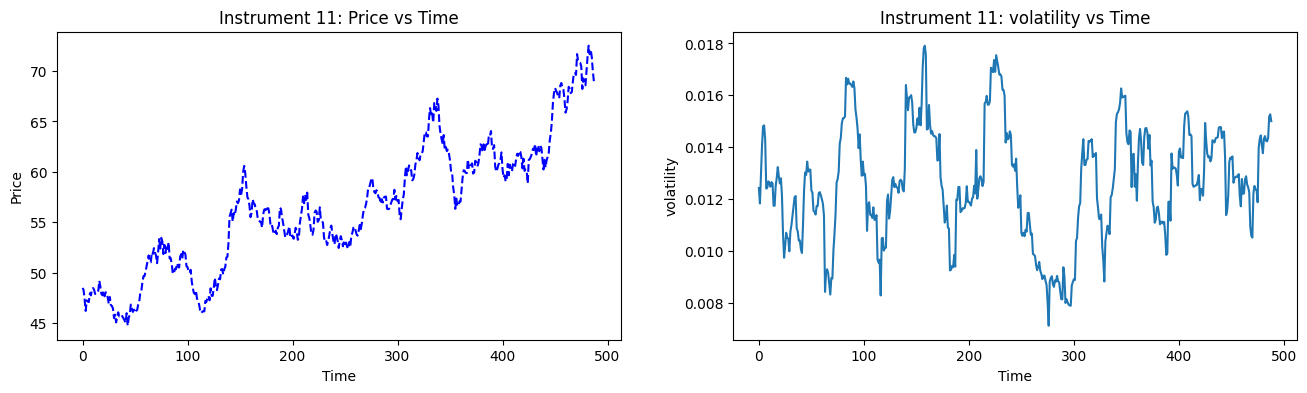

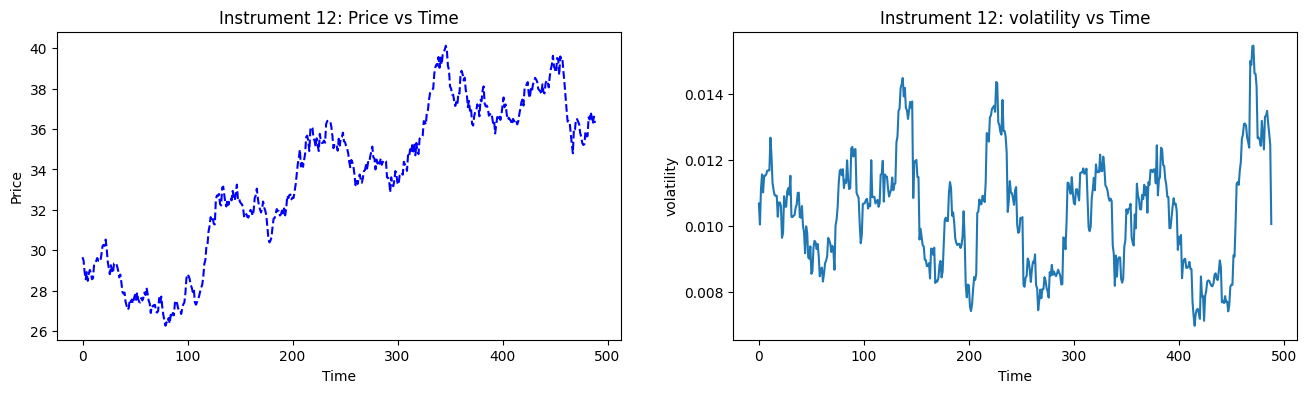

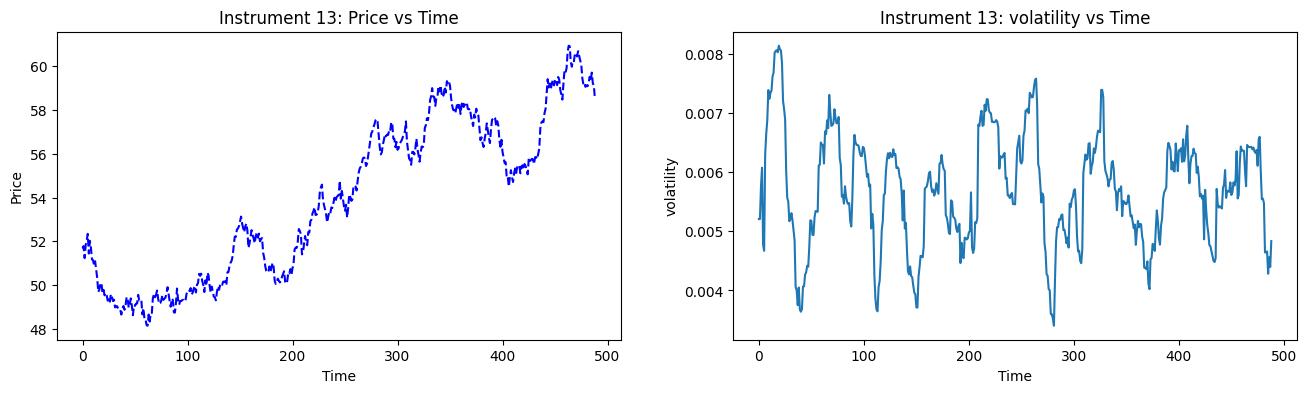

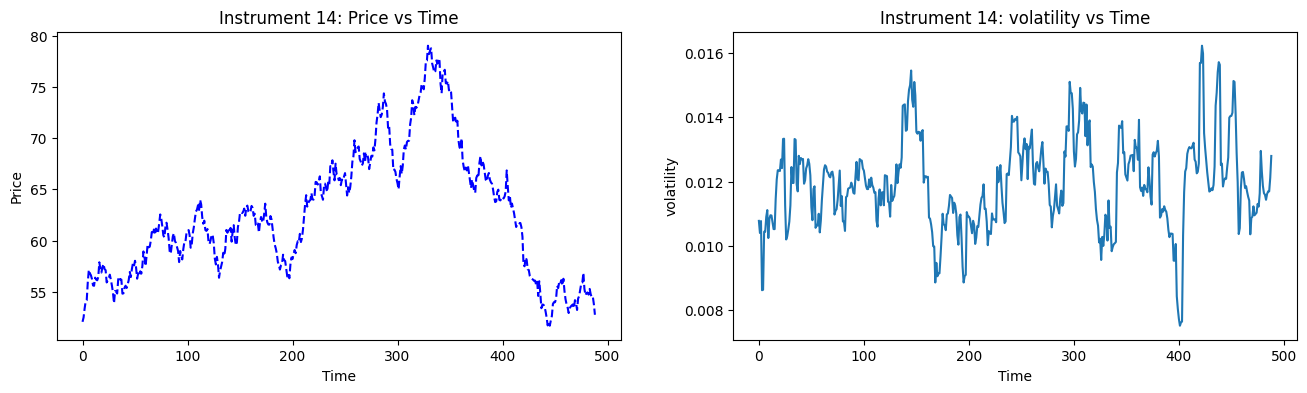

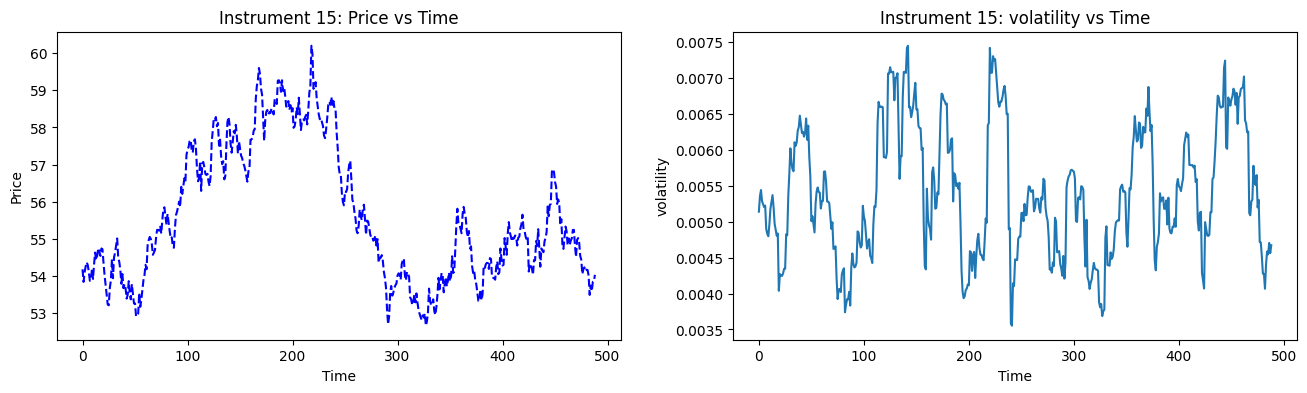

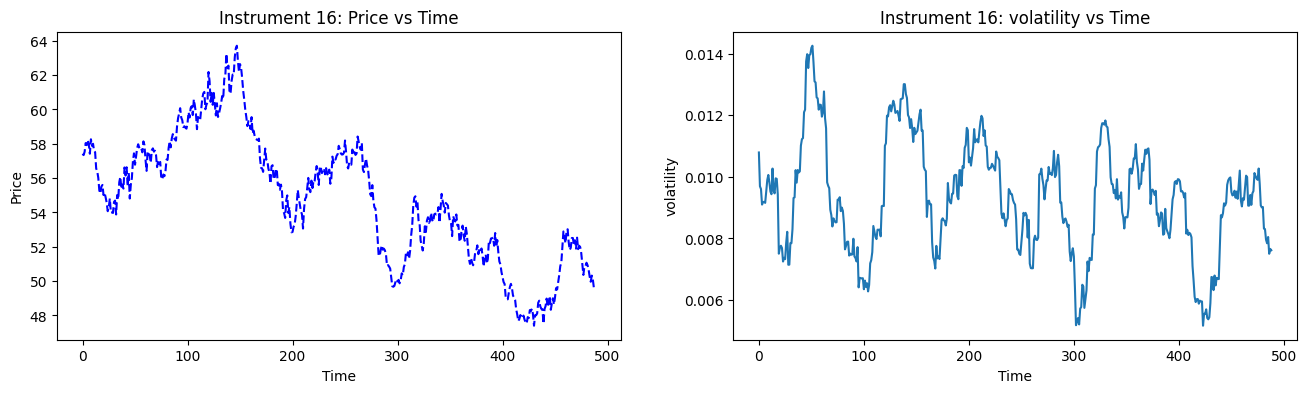

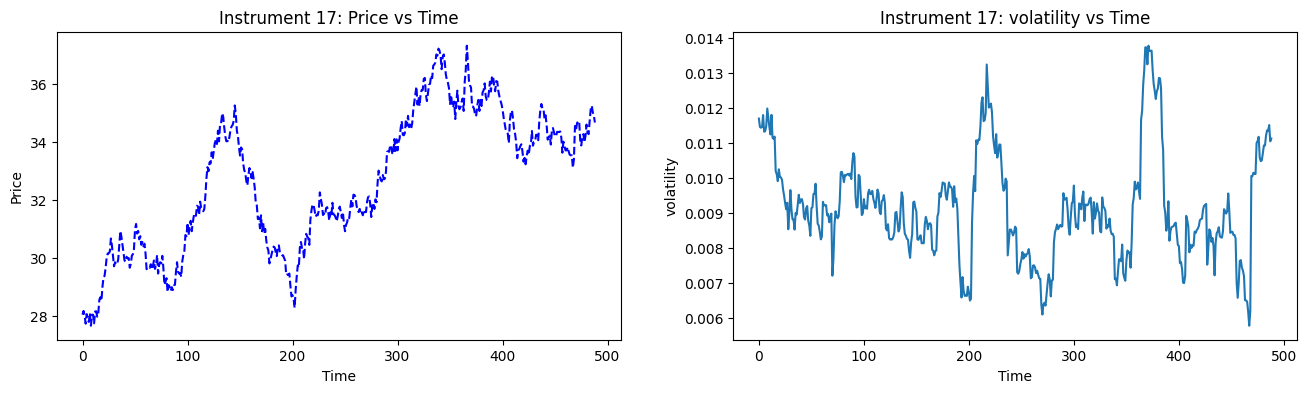

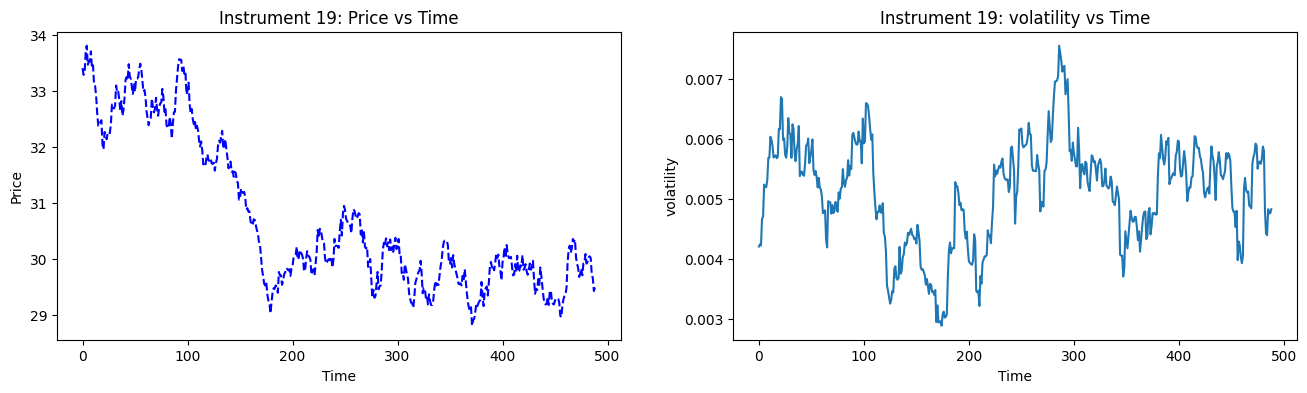

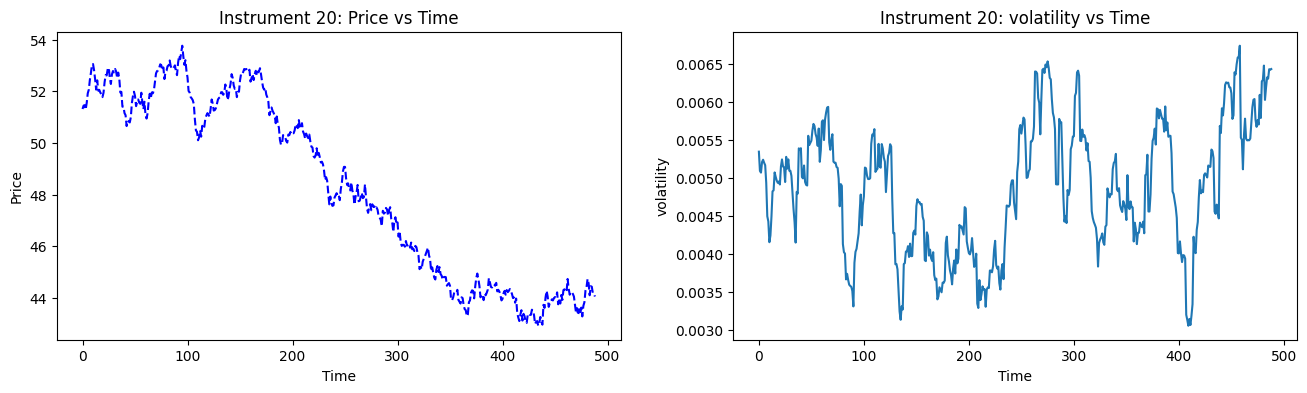

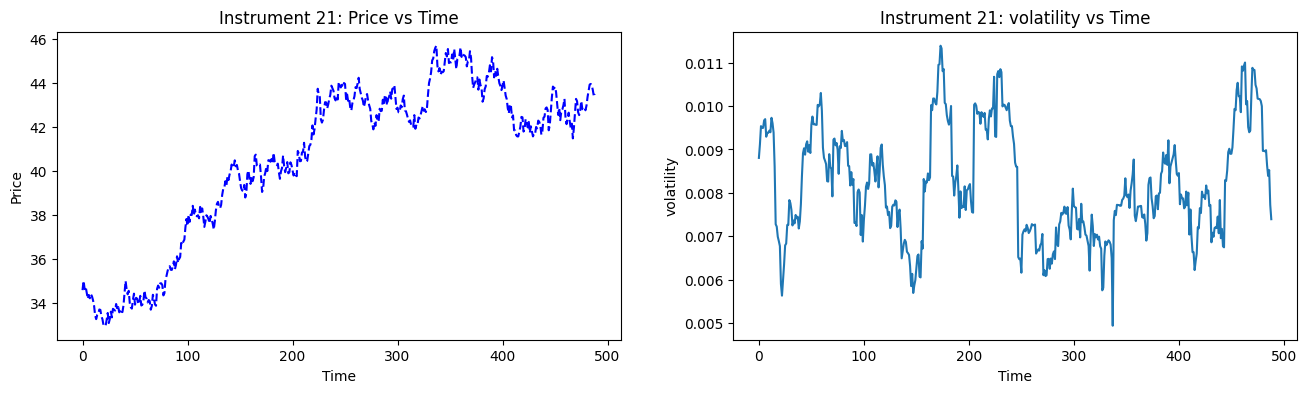

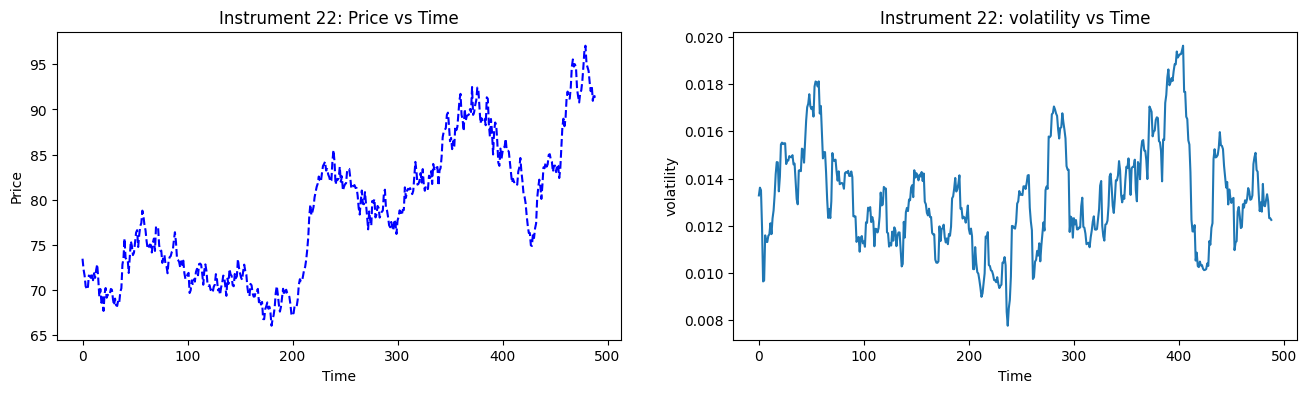

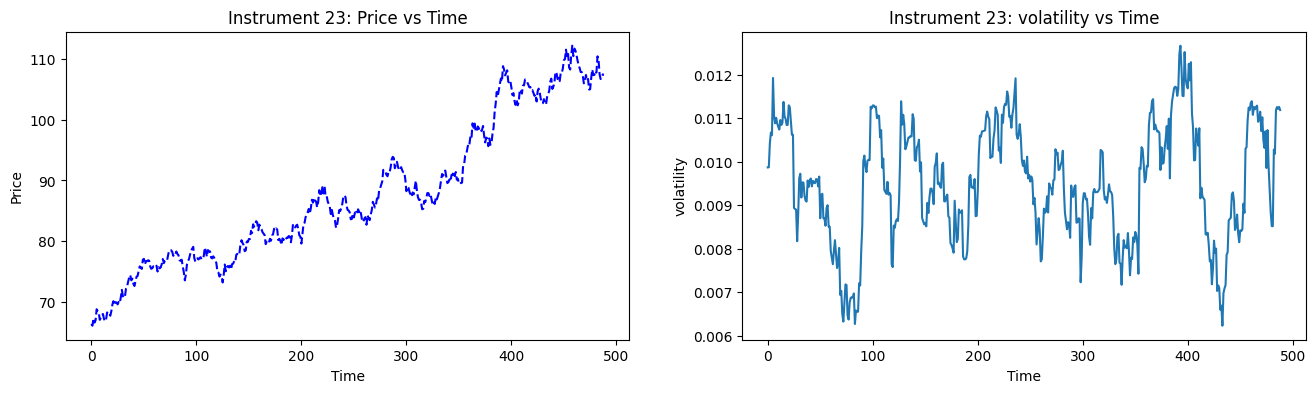

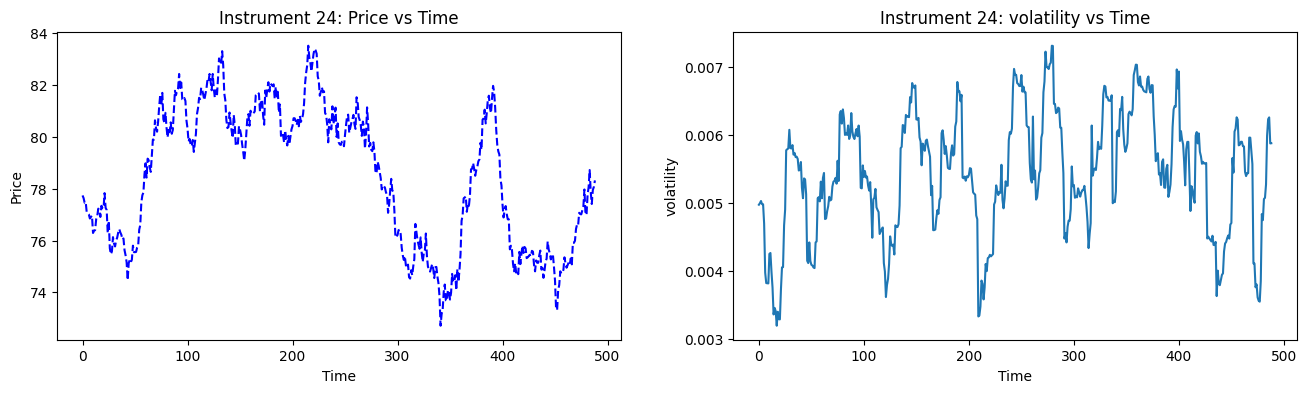

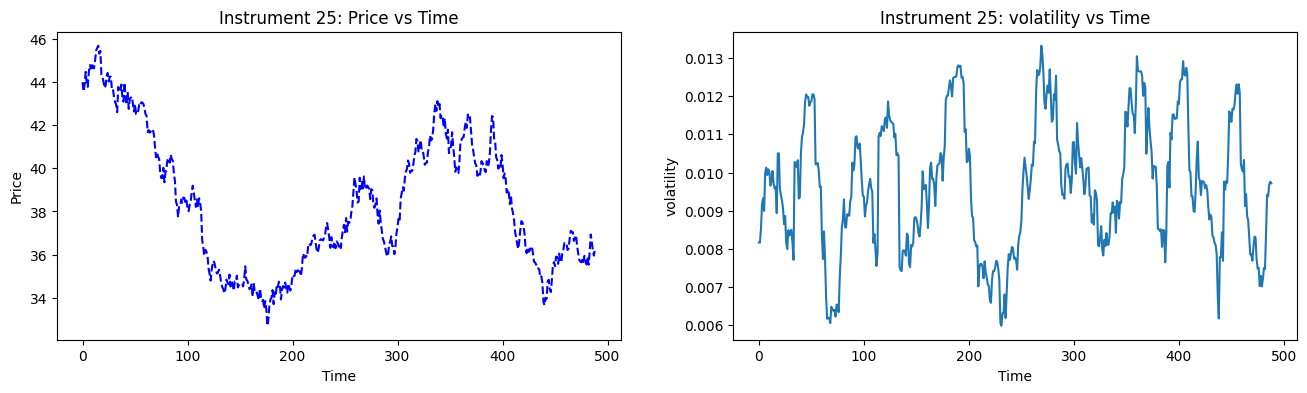

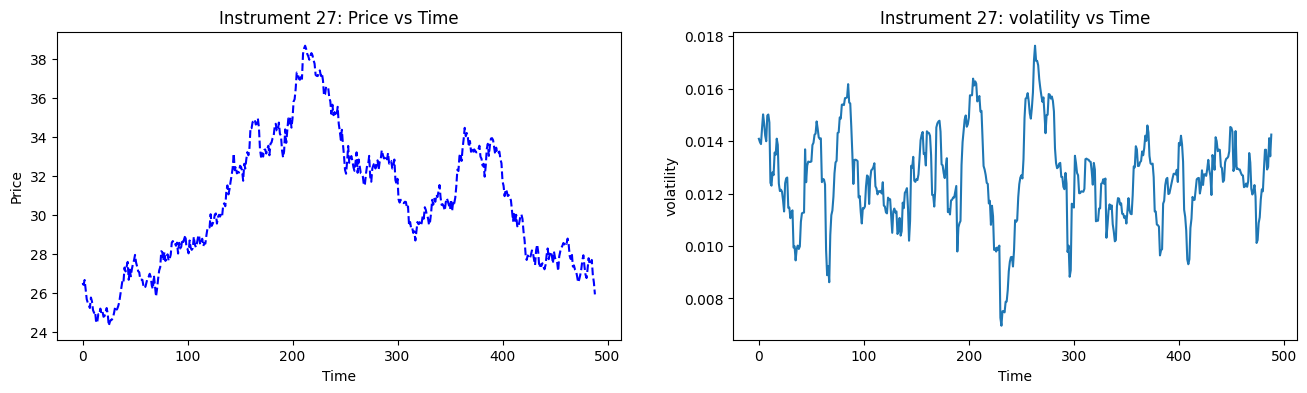

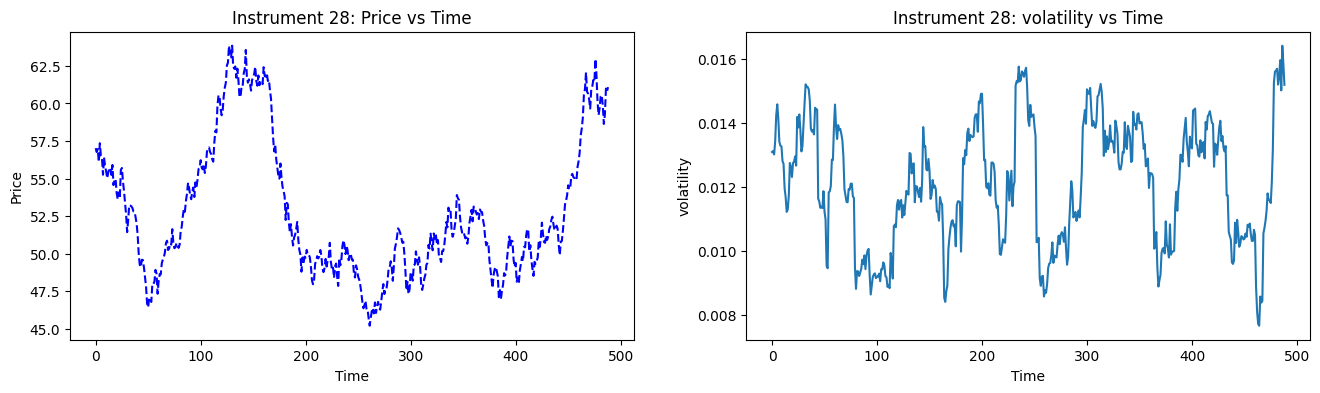

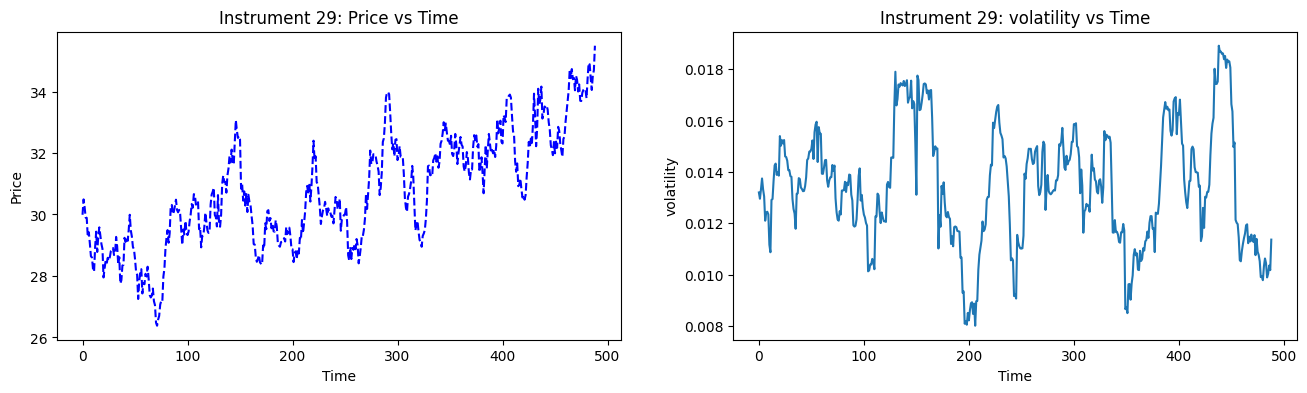

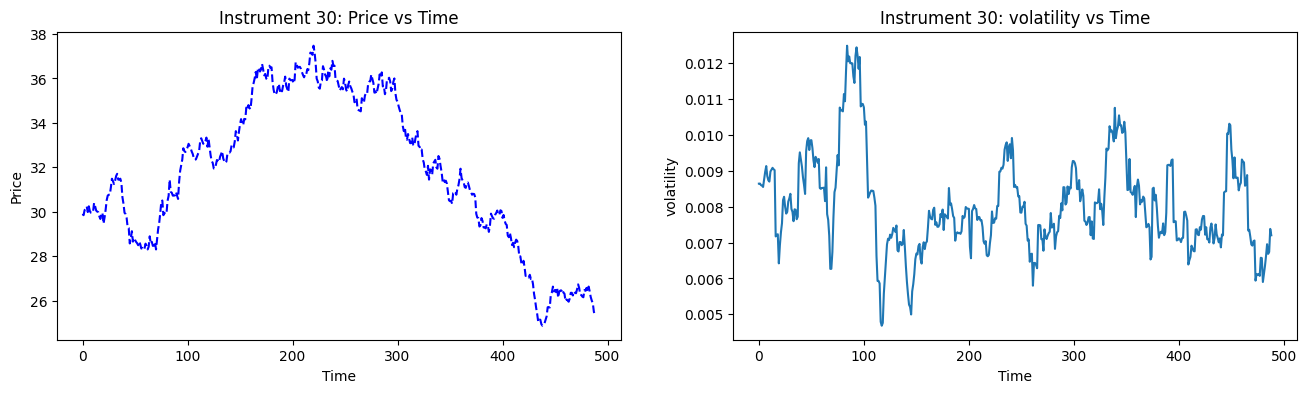

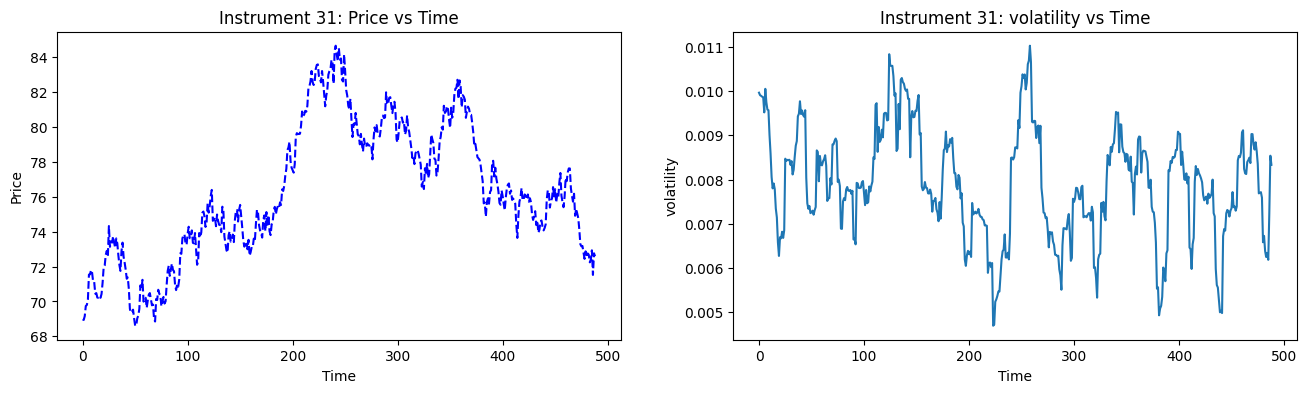

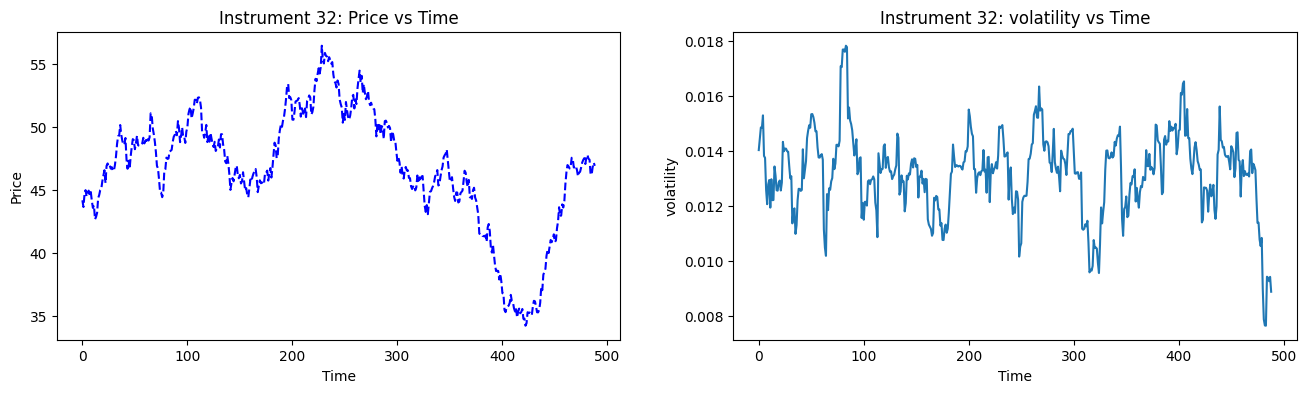

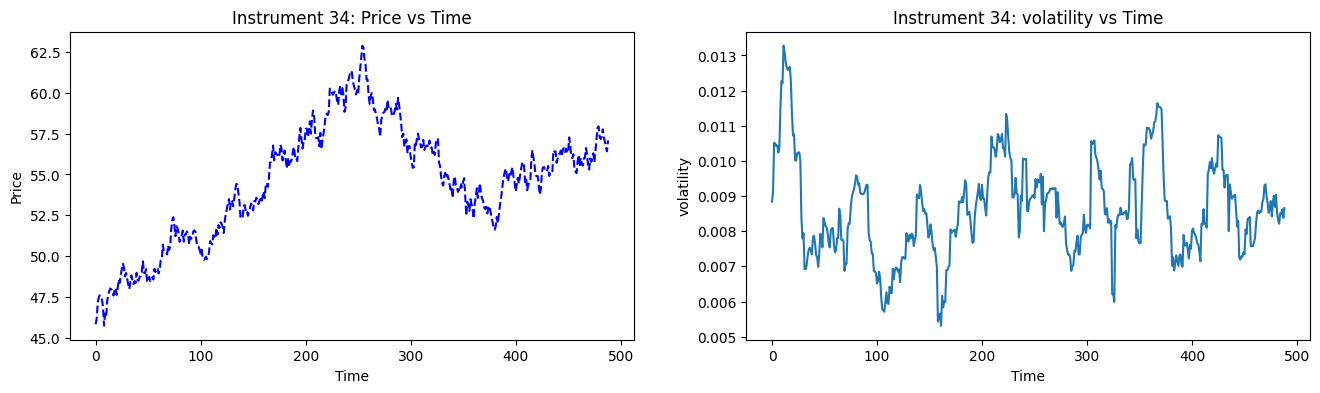

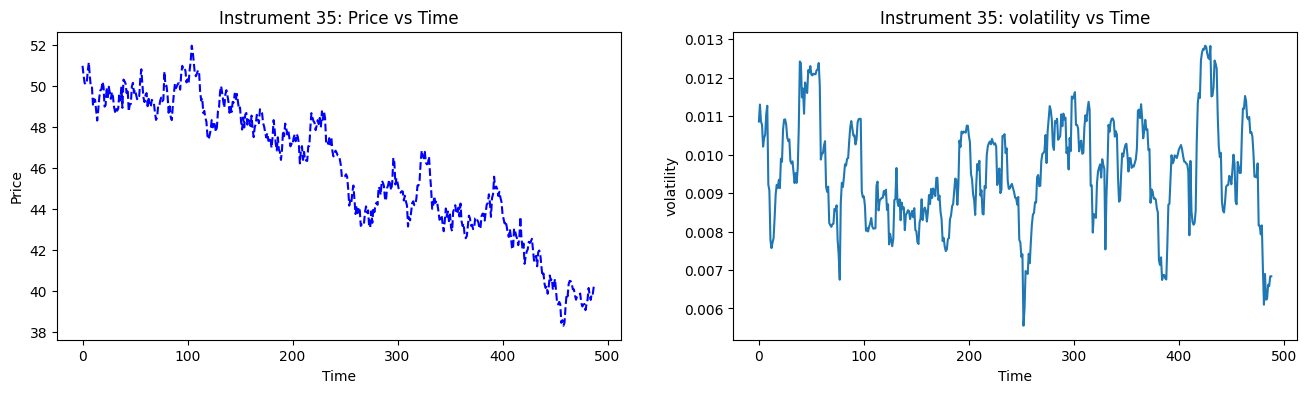

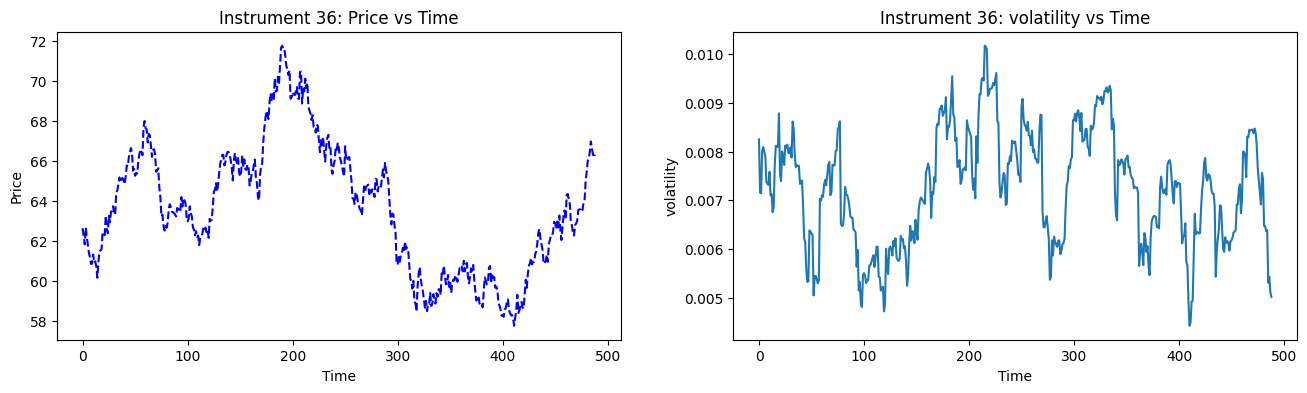

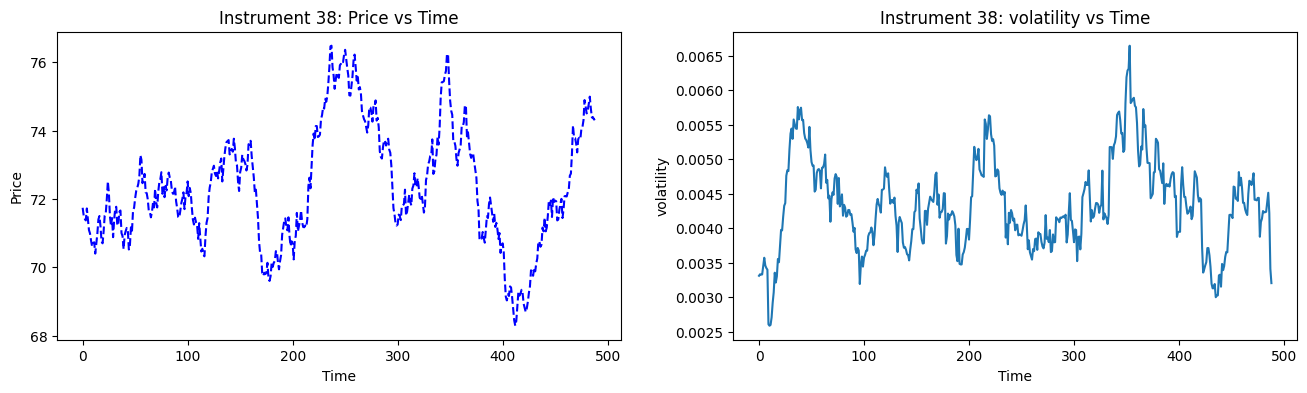

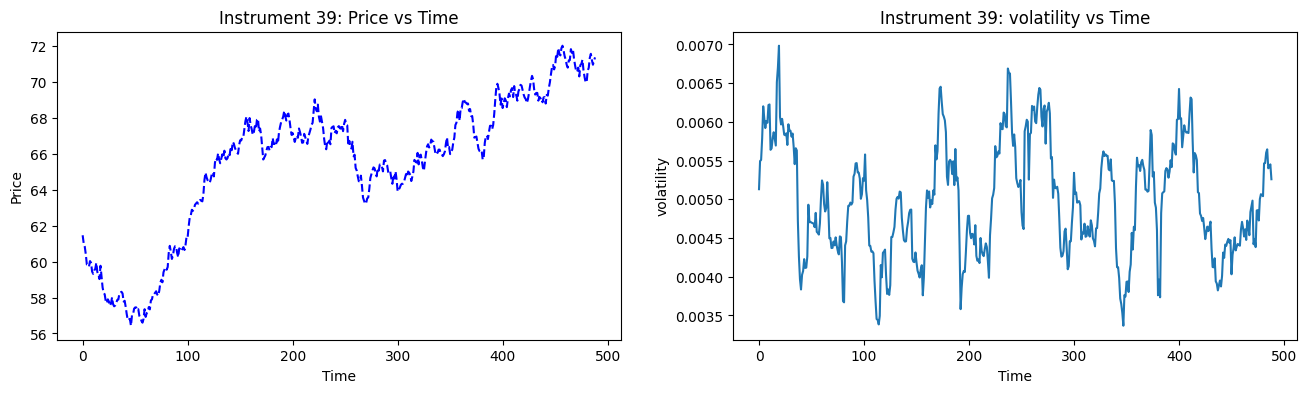

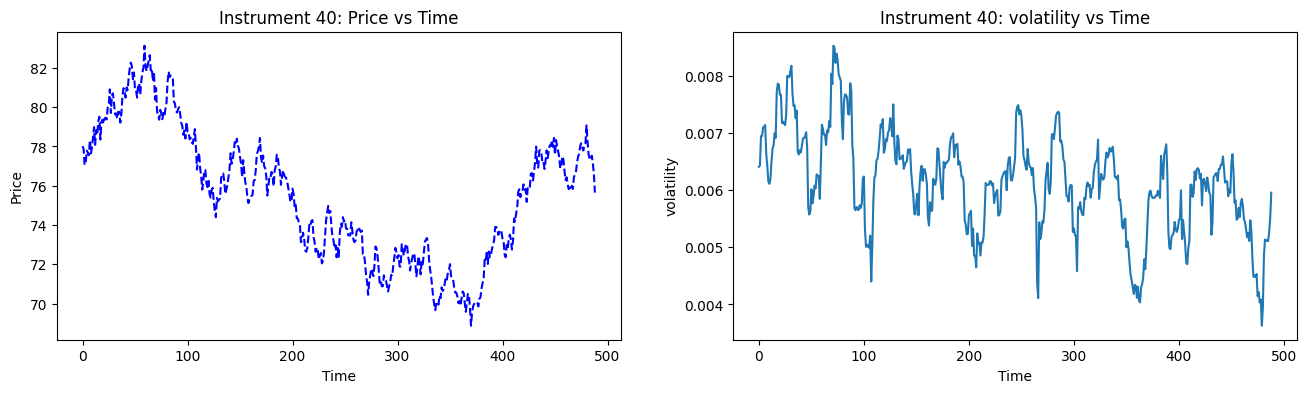

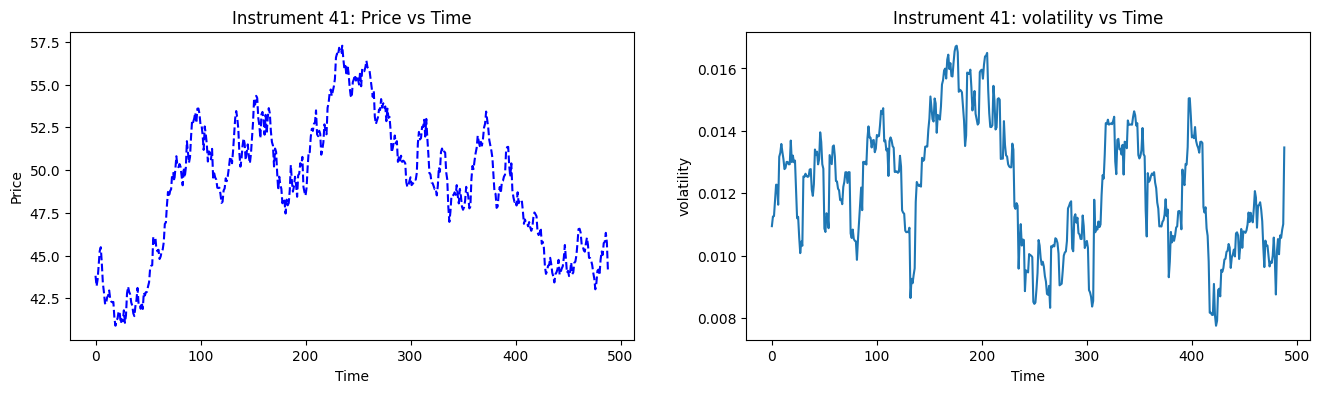

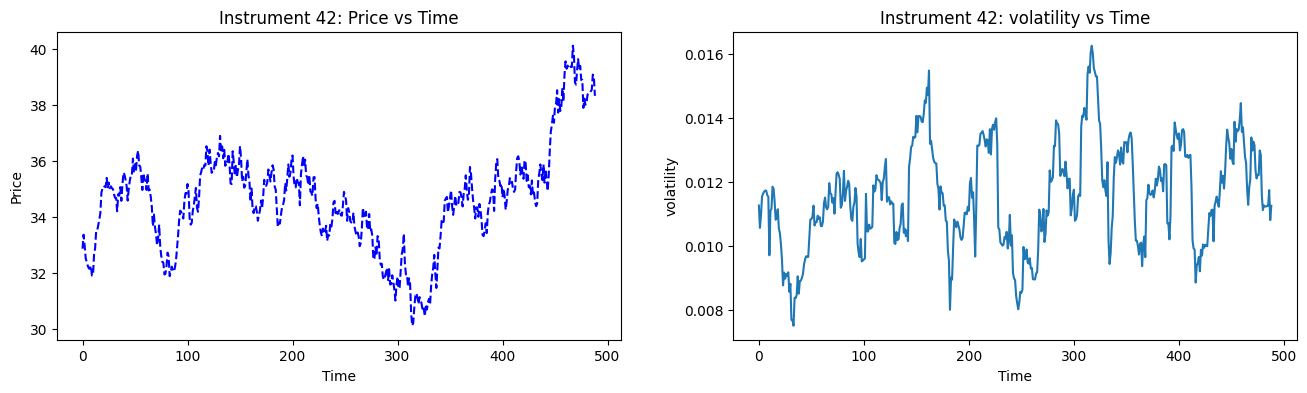

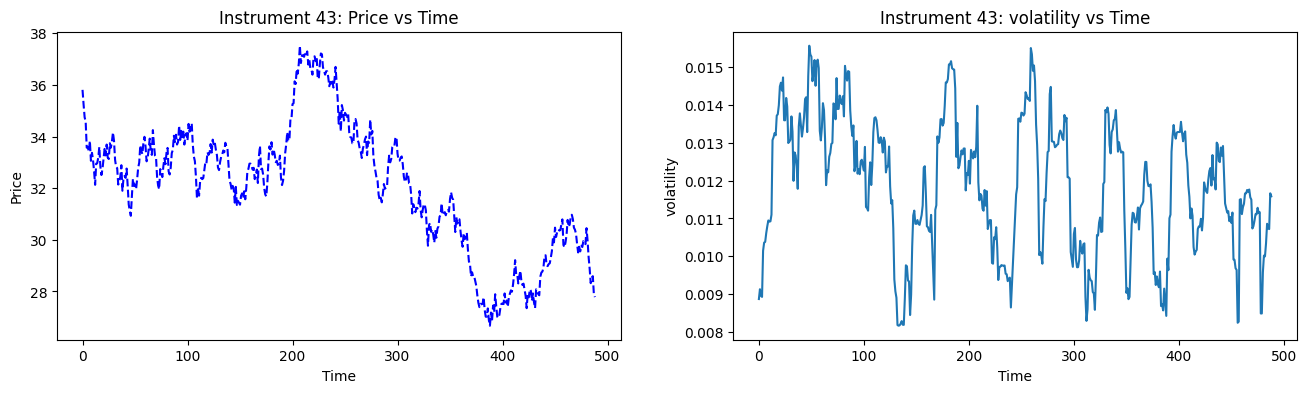

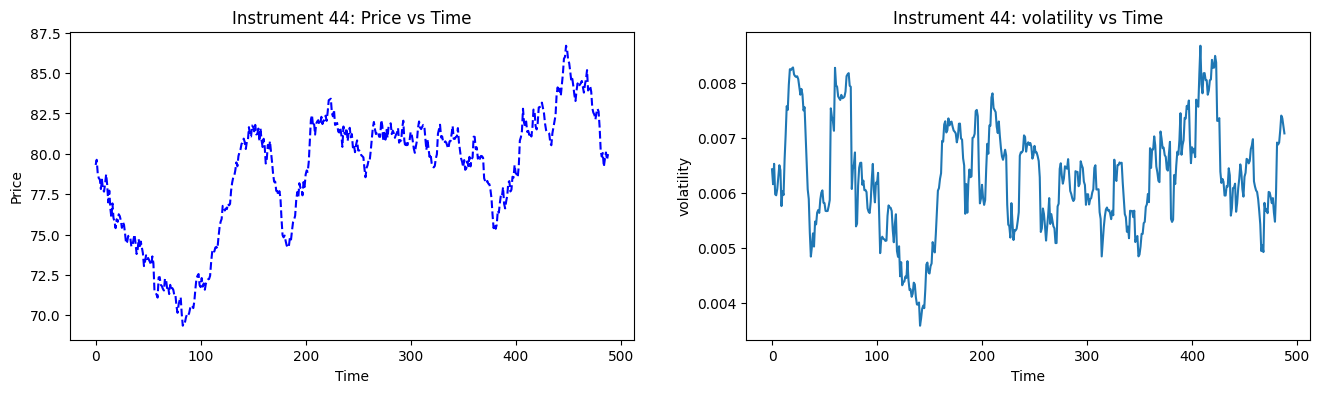

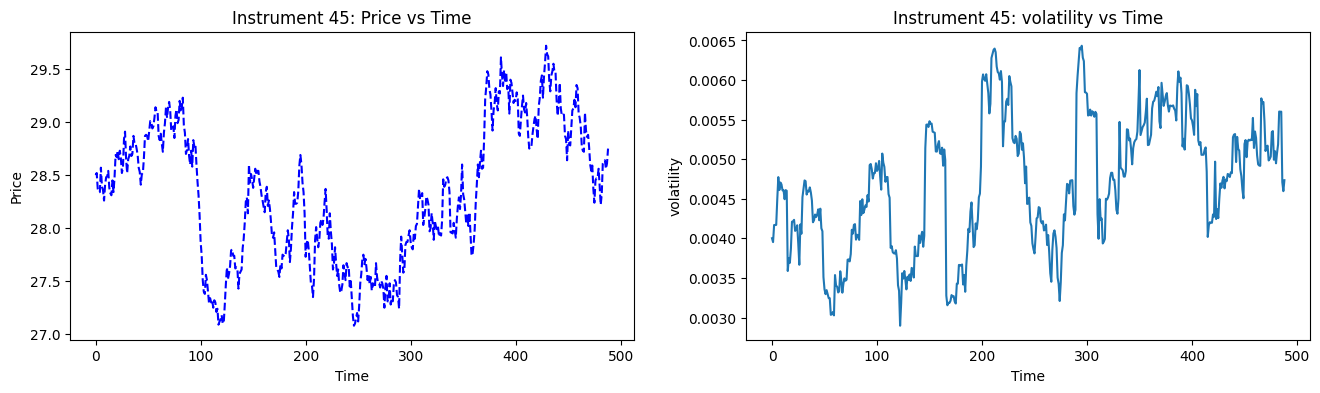

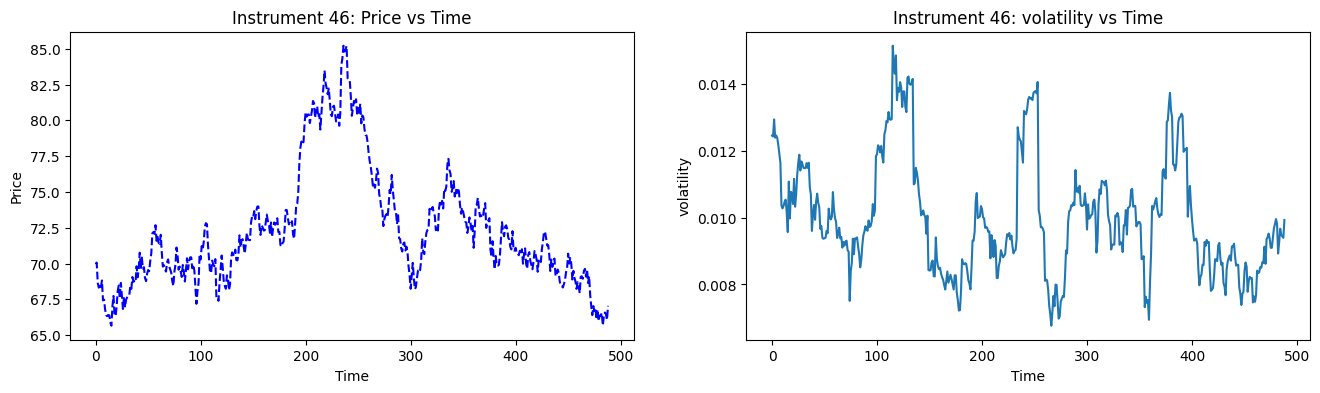

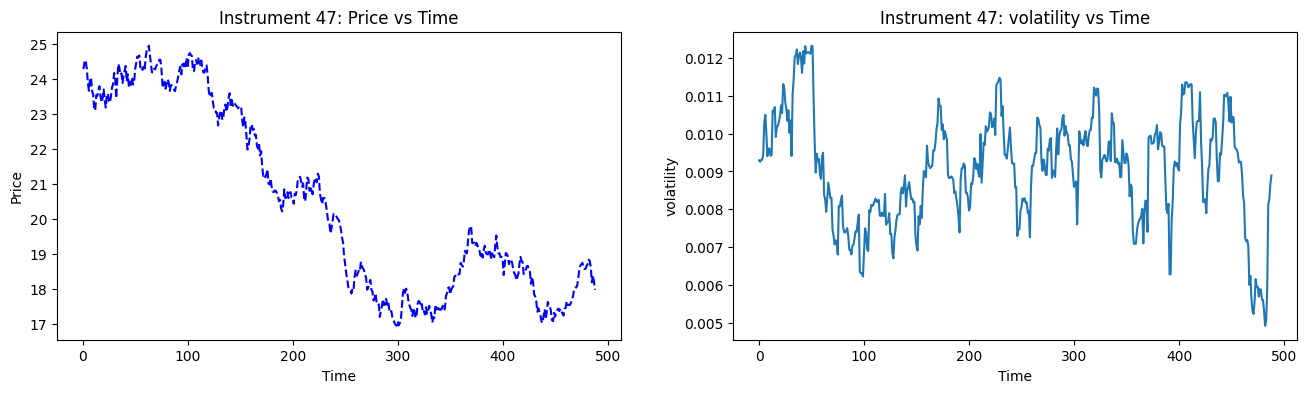

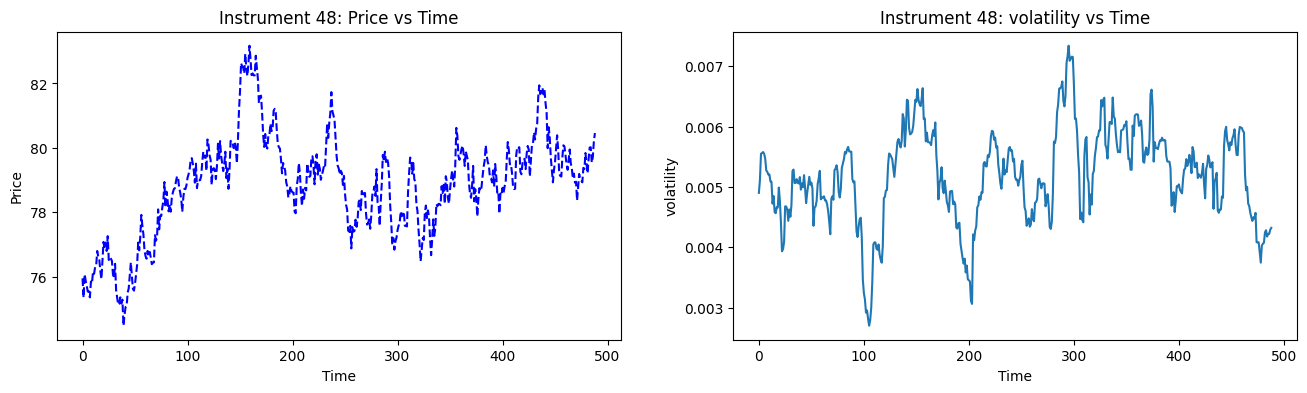

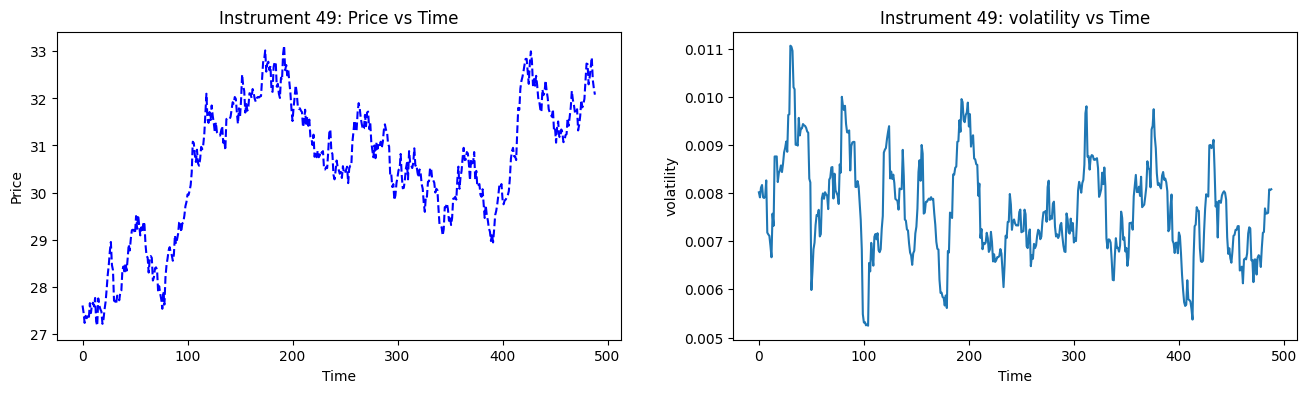

In [80]:
def setup_data() -> Dict[int, DataFrame]:
	data: Dict[int, DataFrame] = get_non_stationary_instruments(0, 550)
	data = implement_response(data)
	
	params: Dict[int, Dict[str, int]] = {
		instrument_no: {
			"rsi_lookback": 21,
			"vol_lookback": 20,
			"slow_ema_lookback": 50,
			"fast_ema_lookback": 10
		} for instrument_no in data
	}
	data = implement_rsi(data, params)
	data = implement_volatility(data, params)
	data = implement_ema_crossover(data, params)
	data = implement_returns(data)
	
	for instrument_no in data:
		data[instrument_no] = data[instrument_no].iloc[CUTOFF:].reset_index(drop=True)
	
	return data

def plot_predictors_vs_response(data: Dict[int, DataFrame]) -> None:
	for instrument_no in data:	
		# Get predictors and response
		rsi: Series = data[instrument_no]["rsi"]
		vol: Series = data[instrument_no]["volatility"]
		ema_crossover: Series = data[instrument_no]["ema_crossover"]
		response: Series = data[instrument_no]["response"]
		
		fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
		
		# Plot RSI
		ax1.scatter(rsi, response, marker="o")
		ax1.set_xlabel("RSI")
		ax1.set_ylabel(f"{returns_lookforward} Day returns")
		ax1.set_title(f"Instrument {instrument_no} RSI vs Returns")

		ax2.scatter(vol, response, marker="o")
		ax2.set_xlabel("Volatility")
		ax2.set_ylabel(f"{returns_lookforward} Day returns")
		ax2.set_title(f"Instrument {instrument_no} Volatility vs Returns")
		
		ax3.scatter(ema_crossover, response, marker="o")
		ax3.set_xlabel("EMA Crossover")
		ax3.set_ylabel(f"{returns_lookforward} Day returns")
		ax3.set_title(f"Instrument {instrument_no} EMA Crossover vs Returns")
		
		plt.show()

def plot_price_with_predictor(data: Dict[int, DataFrame], predictor_key: str) -> None:
	for instrument_no in data:
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
		
		price: Series = data[instrument_no]["price"]
		predictor: Series = data[instrument_no][predictor_key]
		
		ax1.plot(price, linestyle="--", color="blue")
		ax1.set_xlabel("Time")
		ax1.set_ylabel("Price")
		ax1.set_title(f"Instrument {instrument_no}: Price vs Time")
		
		ax2.plot(predictor)
		ax2.set_xlabel("Time")
		ax2.set_ylabel(predictor_key)
		ax2.set_title(f"Instrument {instrument_no}: {predictor_key} vs Time")
		
		plt.show()

data: Dict[int, DataFrame] = setup_data()
plot_price_with_predictor(data, "volatility")